# Life Expectancy

In [1]:
# This is the only extra package for R that we need in this file
install.packages('tidyverse')


The downloaded binary packages are in
	/var/folders/3p/gpwzz_fj5w708pzpgyvx_jqc0000gn/T//RtmpsD33vm/downloaded_packages


In [2]:
# Import the sets of functions that we may need
library(readxl)
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.3     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
# To set the size of the graph as our outpub
options(
    repr.plot.width = 8 * 1.618, 
    repr.plot.height = 8
)

In [15]:
# Read the data
life_expectancy_both_sex <- 
    read_csv(
        file = "https://raw.githubusercontent.com/haoruiii/U-Michigan-FA23-Soc-430/main/WPP2019_MORT_BOTH%20SEXES_LIFE_EXPECTANCY.csv", 
        skip = 16
    )

Rows: 255 Columns: 21
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (18): Variant, Region, subregion, country or area *, Notes, Type, 1950-1...
dbl  (3): Index, Country code, Parent code

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
# Raw Operation: Data selection and tidying
life_expectancy_both_sex_adjusted <-
    life_expectancy_both_sex %>% 
    # Rename the long column name with a shorter one, so that later codes are easier
    select(
        'Area' = `Region, subregion, country or area *`, 
        `1950-1955`:`2010-2015`
    ) %>% 
    # Leave only the rows I needed, i.e. the data for the PRC and the World
    filter(
        Area %in% c('China', 'China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of China', 'WORLD')
    ) %>% 
    # Tidying the data, only with which can we have futher operations
    pivot_longer(
        cols = c(`1950-1955`:`2010-2015`), 
        names_to = 'Period', 
        values_to = 'Value'
    ) %>% 
    # Round the values to 3 decimals
    mutate(Value = round(parse_double(Value), 3))

In [18]:
life_expectancy_both_sex_mean <- 
    life_expectancy_both_sex_adjusted %>% 
    # Leave only PRC data for the calculation of means
    filter(Area != 'WORLD') %>% 
    group_by(Period) %>% 
    # Calculate the mean of four subregions in the PRC in each period
    summarize(Average = round(mean(Value), 3)) %>% 
    # Adjust the shape of this table, so that it's the same as our main table
    mutate(Area = 'Average in PRC', .before = 1) %>% 
    rename(Value = 'Average')

In [19]:
# Combine the two tables, the main table and the one with averages, together
life_expectancy_both_sex_graphing <- 
    rbind(life_expectancy_both_sex_adjusted, life_expectancy_both_sex_mean) %>% 
    rename(`Value For:` = 'Area')

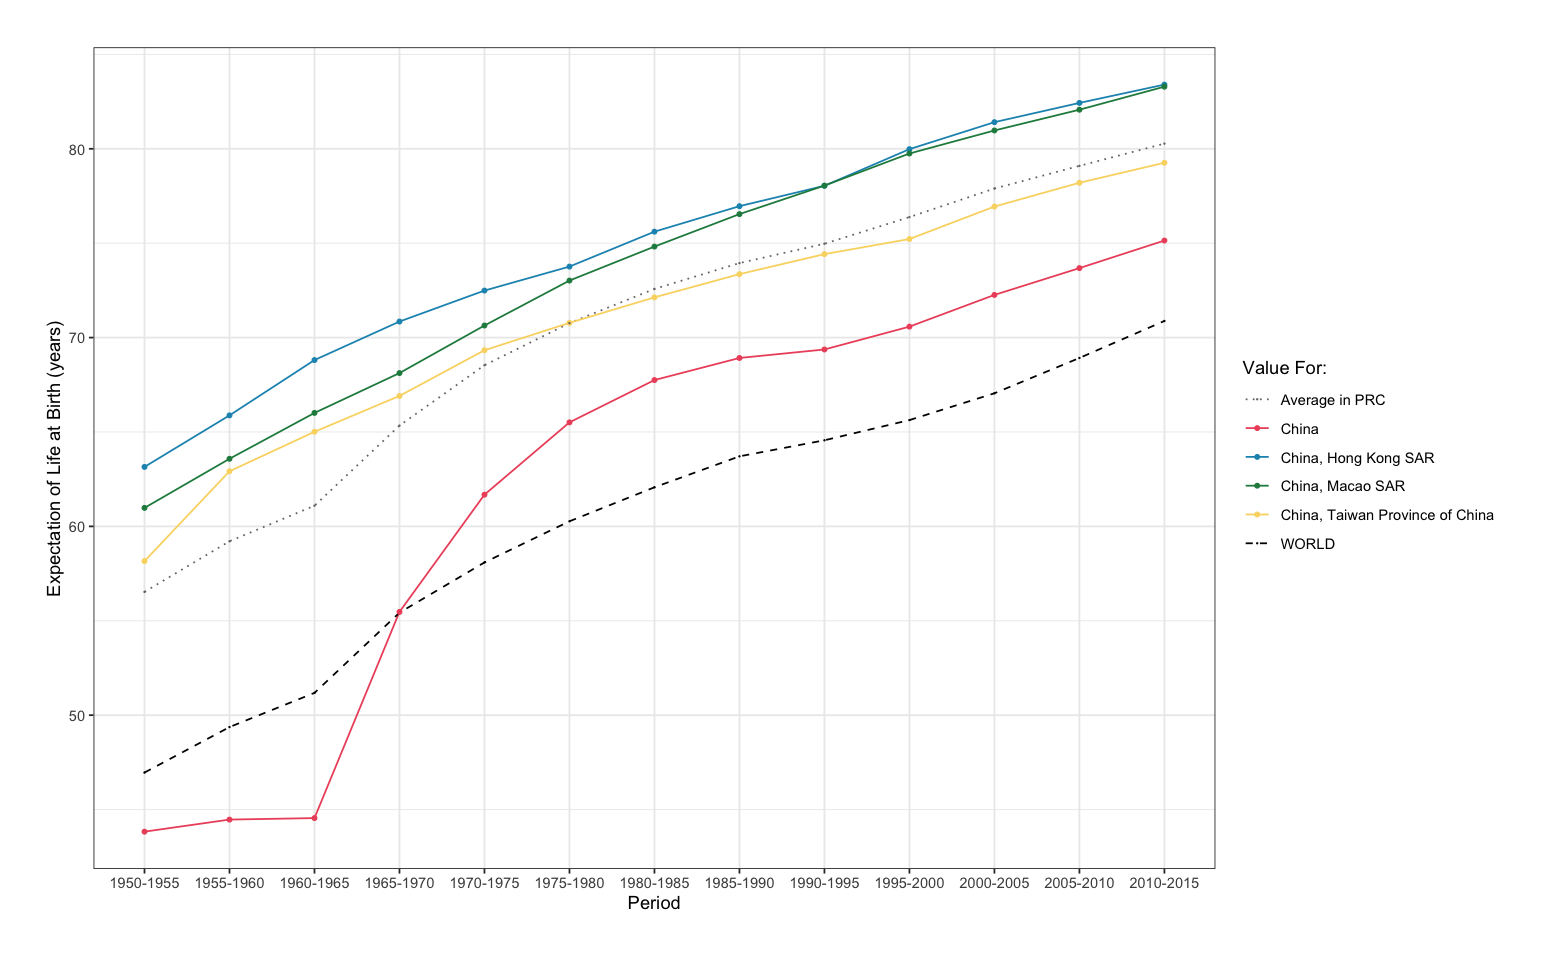

In [20]:
# Graphing
life_expectancy_both_sex_graphing %>% 
# Basic setting, esp. introducing the values on both axises
ggplot(
    mapping = aes(
        x = Period, 
        y = Value, 
        group = `Value For:`, 
        color = `Value For:`, 
        linetype = `Value For:`
    )
) + 
# Indicate that our type of plot is line plot
geom_line() + 
# We also want points on the lines
geom_point(
    mapping = aes(
        size = `Value For:`
    )
) + 
# Manually set the lables for x-axis, y-axis, and title
labs(
    x = "Period", 
    y = "Expectation of Life at Birth (years)", 
    # title = "People's Expectation of Life at Birth for Both Sex Combined in the PRC and World from 1950 to 2015"
) + 
# Have a black-and-white theme (for the background?)
theme_bw() + 
# Manually set the sizes of the dots: the smaller the values are, the smaller the points are
scale_size_manual(
    values = c(
        'Average in PRC'                    = 0, 
        'China'                             = 1, 
        'China, Hong Kong SAR'              = 1, 
        'China, Macao SAR'                  = 1, 
        'China, Taiwan Province of China'   = 1, 
        'WORLD'                             = 0
    )
) + 
# Manually set the types of lines
scale_linetype_manual(
    values = c(
        'Average in PRC'                    = 'dotted', 
        'China'                             = 'solid', 
        'China, Hong Kong SAR'              = 'solid', 
        'China, Macao SAR'                  = 'solid', 
        'China, Taiwan Province of China'   = 'solid', 
        'WORLD'                             = 'dashed'
    )
) + 
# Manually set the colors of our lines
scale_color_manual(
    values = c(
        'Average in PRC'                    = '#7a7374', 
        'China'                             = '#ed556a', 
        'China, Hong Kong SAR'              = '#1a94bc', 
        'China, Macao SAR'                  = '#20894d', 
        'China, Taiwan Province of China'   = '#f9d770', 
        'WORLD'                             = '#000000'
    )
) + 
theme(
    # Set the size of margins on each side of our graph
    plot.margin = margin(
        t = 1, b = 1, 
        r = 1, l = 1, 
        unit = 'cm'
    ), 
    # Put the title in the middle: 0.5 is the middle between 0 and 1
    plot.title = element_text(hjust = 0.5)
)

In [21]:
# Reshape the table, to be friendly for human reading
life_expectancy_both_sex_graphing %>% 
mutate(Value = round(Value, 2)) %>% 
pivot_wider(
    names_from = 'Value For:', 
    values_from = 'Value'
) %>% 
# Export it to a csv file, with which I can adjust the appearance in Excel
write.csv(file = 'Life Expectancy.csv')